In [1]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import zscore
from tensorflow import keras

/users/isys/tpotdar/pyenvs/lob/lib/python3.6/site-packages/h5py-2.7.0-py3.6-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [24]:
# Constants
# batch size for model
BATCH_SIZE = 100
# number of epochs
EPOCHS = 100
# proportion of validation data
VALIDATION_SPLIT = 0.2
# learning rate and epsilon for ADAM optimizer
LEARNING_RATE = 0.01
EPSILON = 1
# path where data is stored
PATH="/users/isys/tpotdar/projects/thesis/data/INTC_2015-01-01_2015-01-31_10"
# prediction horizon
K = 50 
# threshold to decide which category midprice direction falls in (up, down, stationary)
ALPHA = 0.001
# first 10 days are used to train, 6 for val and 4 for test (TSLA and INTC each have 20 working days of data)
days = list(range(20))
train_days = days[:10]
val_days = days[10:16]
test_days = days[16:20]

# Static objects
# instantiate one hot encoder here so that all classes will always map to the same labels
onehot_encoder = OneHotEncoder(sparse=False)

# column names
levels = 10
nums = map(str, range(1,levels+1))
col_names = [y + x for x in nums for y in ['ask_price_', 'ask_size_', 'bid_price_', 'bid_size_']]

## Preprocess the data

In [3]:
all_files = glob.glob(PATH + "/*orderbook_10.csv")
all_files.sort()

def read_data(days):
    dfs = []
    print("Reading")
    for filename in [all_files[i] for i in days]:
        df = pd.read_csv(filename, index_col=None, header=None, names=col_names)
        dfs.append(df)
    data = pd.concat(dfs, axis=0, ignore_index=True)
    return data

train_data = read_data(train_days)
test_data = read_data(test_days)
val_data = read_data(val_days)

Reading
Reading
Reading


In [4]:
# smoothed labelling of the midprice/ K is the prediction horizon
def smooth_midprice_using_k_lookahead(data, k):
    normalised_data = data.apply(zscore)
    normalised_data['midprice'] = (normalised_data.ask_price_1+normalised_data.bid_price_1)/2
    # mean of previous k mid-prices
    normalised_data['m_minus'] = normalised_data['midprice'].rolling(window=k).mean()
    # mean of next k mid-prices
    normalised_data['m_plus'] = normalised_data['midprice'][::-1].rolling(window=k).mean()[::-1]
    return normalised_data

In [5]:
# label the smoothed mid-prices based on a threshold/ ALPHA is the threshold 
def create_midprice_labels(normalised_data):
    normalised_data['change'] = (normalised_data.m_plus - normalised_data.m_minus)/normalised_data.m_minus
    # assign categories up, down, stationary
    normalised_data['label'] = pd.cut(normalised_data.change, bins=[-np.inf, -ALPHA, ALPHA, np.inf], 
                                    labels=['down', 'stationary', 'up'])
    # drop all unlabelled values (will be first and last k values as they have no m_minus/m_plus value)
    normalised_data.dropna(inplace=True)
    return normalised_data

In [6]:
def reshape_and_categorise_data(normalised_data):
    n = len(normalised_data) - len(normalised_data)%100
    data = normalised_data[:n]
    
    # reshape input data into the shape of (batches, 100, 40, 1) as one input has 100 timesteps with 40 features
    input_data = data[col_names]
    input_array = input_data.values.reshape(n//100,100,40,1)
    
    # choose every 100th value as the output label/ 100 timesteps predict the 100th price move direction
    output_data = data.label.values[::-100][::-1]
    
    # encode labels to vectors
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(output_data)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    output_array = onehot_encoder.fit_transform(integer_encoded)
    return input_array, output_array

In [8]:
# data normalisation, smoothing and labelling
def preprocess_data(data, k, data_type):
    data = smooth_midprice_using_k_lookahead(data, k)
    data = create_midprice_labels(data)
    X, y = reshape_and_categorise_data(data)
    print("{} input shape:".format(data_type), X.shape)
    print("{} output shape:".format(data_type), y.shape)
    return X, y

X_train, y_train = preprocess_data(train_data, k=K, data_type="Training")
X_val, y_val = preprocess_data(val_data, k=K, data_type="Validation")
X_test, y_test = preprocess_data(test_data, k=K, data_type="Test")

Training input shape: (99456, 100, 40, 1)
Training output shape: (99456, 3)
Validation input shape: (48626, 100, 40, 1)
Validation output shape: (48626, 3)
Test input shape: (38747, 100, 40, 1)
Test output shape: (38747, 3)


In [10]:
# mapping of labels to one hot encoding
# encodings = [[1,0,0],[0,0,1],[0,1,0]]
# classes = onehot_encoder.inverse_transform(encodings)
# print(zip(classes, encodings))
# Using np.argmax equates: 0-down, 1-stationary, 2-up

### Build and compile the model

In [19]:
def create_model():
    # convolutional layers
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), input_shape=(100,40,1), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,10), input_shape=(100,10,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(3,1)))
    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

    # lstm layer
    model.add(keras.layers.LSTM(100,kernel_regularizer=keras.regularizers.l2(0.01),return_sequences=False,activation='relu'))
    model.add(keras.layers.Dropout(0.50))
    model.add(keras.layers.Dense(3,activation='softmax'))
    # compile model and summarize
    adam = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
model = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 100, 20, 16)       48        
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 100, 20, 16)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 97, 20, 16)        1040      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 94, 20, 16)        1040      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 94, 10, 16)        528       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 94, 10, 16)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 91, 10, 16)        1040      
__________

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback], 
                    validation_data=(X_val, y_val), verbose=1)
score, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Accuracy is {}%".format(accuracy*100))

Train on 99456 samples, validate on 48626 samples
Epoch 1/100
99456/99456 [==============================] - 331s 3ms/step - loss: 1.0100 - acc: 0.5514 - val_loss: 1.0058 - val_acc: 0.5503
Epoch 2/100
99400/99456 [============================>.] - ETA: 0s - loss: 0.9766 - acc: 0.5537

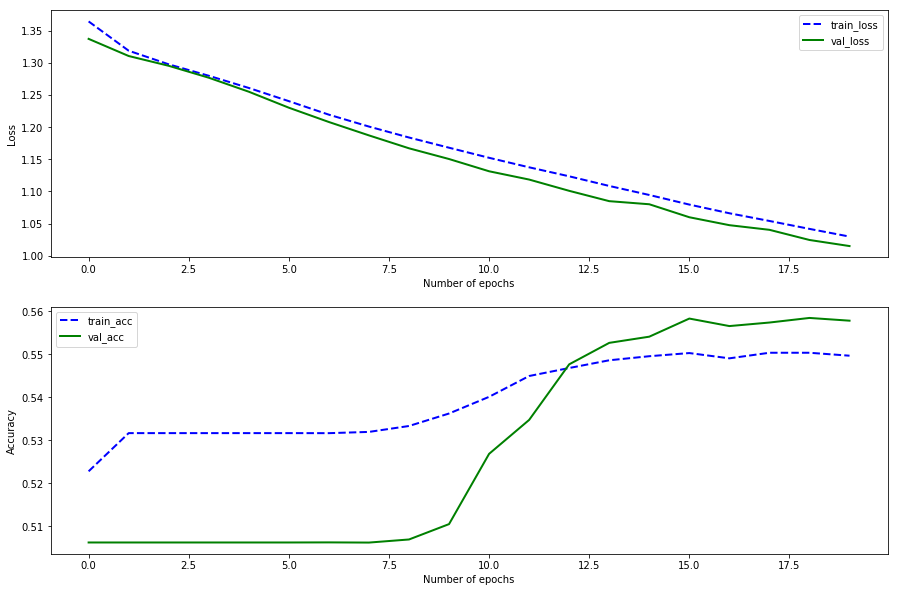

In [21]:
def plots(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
    plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
    plt.legend()
    # plt.ylim([.5,1.3])
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.subplot(2,1,2)
    plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
    plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
    plt.legend()
    # plt.ylim([.2,1.0])
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.show()
plots(history)

### Evaluate performance

In [22]:
def get_report(model, X_test, y_test, X_train, y_train):
    target_names = ['down', 'stationary', 'up']
    y_pred = model.predict(X_test)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = np.argmax(y_test, axis=1)
    print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
    print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))
get_report(model, X_test, y_test, X_train, y_train)

             precision    recall  f1-score   support

       down       0.09      0.37      0.14      2319
 stationary       0.80      0.60      0.68     25580
         up       0.40      0.36      0.38     10848

avg / total       0.64      0.52      0.57     38747

[[  862  5237  3740]
 [  691 15277  3207]
 [  766  5066  3901]]


In [ ]:
[all_files[i] for i in train_days]